KMC3 Data Processing HOWTO
==========================

This demonstrates how to use the [nx5d](https://gitlab.com/codedump2/nx5d) Python package to load, convert and anlyse X-ray diffraction (XRD) data generated at the BESSY-II KMC3-XPP beamline.

You're likely to be accessing this Jupyer Lab account right now on the [KMC3 beamline control computer](http://kmc3-xpp.basisit.de:8888). You should have received the password from the endstation administration team (Matthias or Florin, as of writing this), or perhaps you're using an already authenticated session. That's alright.

The Jupyter Lab URL ([http://kmc3-xpp.basisit.de:8888](http://kmc3-xpp.basisit.de:8888)) is accessible only inside the BESSY-II network. You can read it from the outside via an [SSH tunnel through Aditum](https://www.helmholtz-berlin.de/bin/extern-access?sprache=en).

Get acquainted with your environment
------------------------------------


Your current working directory is either in the "home directory" of the default user `jovyan`, or in a directory that you've selected in the file explorer on the left-hand side. You can use your favorite IPython command to figure that out:

In [1]:
pwd

'/home/jovyan/code/skycontrol/doc/HOWTOs/KMC3 Data Processing'

In [2]:
ls

'KMC3 Data Processing HOWTO.ipynb'*  'KMC3 Data Processing HOWTO.pdf'



Data is available at `~/jovyan/work/...`, where `...` depends on your project.
Typically, there's a year involved (e.g. `.../2023/...`) and a cryptic string containing your proposal number and a shorthand version of your name. For instance:

In [3]:
ls /home/jovyan/work/2023/231-cw7-12082-roessle/

231-cw7-12083-roessle.h5*    Analysis.ipynb*             pilatus/
231-cw7-12083-roessle.spec*  DetectorCalibration.ipynb*


Working with data
-----------------

For the purpose of this example we'll work with the dataset 44 in a file called "231-cw7-12083-roessle.spec" from our 2023 measurements. The `dataPath` tuple below is a combination of the on-disk file path, and of the scan path inside the (HDF5-like) file itself. For convenience, we combine the two in a URL-like scheme `scanUrl` which we'll be using henceforth.

In [4]:
dataPath = ("/home/jovyan/work/2023/231-cw7-12082-roessle/231-cw7-12083-roessle.spec", "44.1")
scanUrl = '#'.join(dataPath)
scanUrl

'/home/jovyan/work/2023/231-cw7-12082-roessle/231-cw7-12083-roessle.spec#44.1'

### Loading and inspecting the "raw" data file

Having located the data on disk, the next step is importing the proper Python libraries for
actually loading that data (you'll need at least `nx5d`) and trying to load the SPEC file
that was generated by the experiment orchestration software.

There are several parts to `nx5d`. The most basic, low-level part, is access to the datafile
itself. It doesn't know anything about data organisation (i.e. "scans" etc), so we'll only
be using the file path part of `dataPath`, i.e. `dataPath[0]`.

In [5]:
import nx5d.xrd.kmc3 as kmc3
h5like = kmc3.SpecTiffH5(dataPath[0])

The data object (here called `h5like`) behaves like a
[`h5py.File` object](https://docs.h5py.org/en/stable/high/file.html), which
is probably familiar to you from loading HDF5 files.

At the KMC3-XPP beamline we try to stay compatible with the [ESRF-flavor of the
HDF5/Nexus format](https://bliss.gitlab-pages.esrf.fr/bliss/master/data/data_nexus.html)
for data storage. This means that your data is located somewhere
under a scan name (here "44.1") and a detector name (here "pilatus")
inside the HDF5-like folder named "measurement".

In [6]:
data = h5like["/44.1/measurement/pilatus"]
data.shape

(41, 195, 487)

Basic plotting of raw data works as you've grown to expect from a Jupyter
environment.

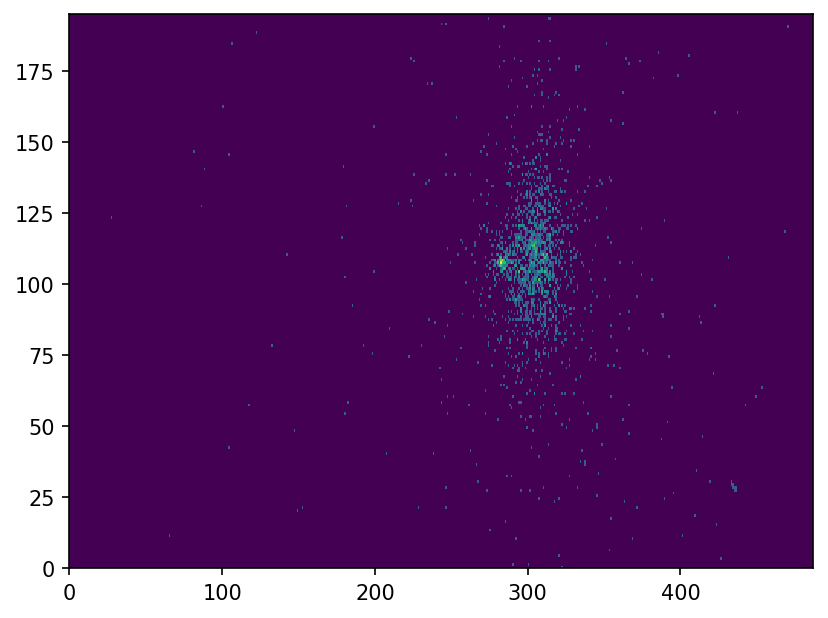

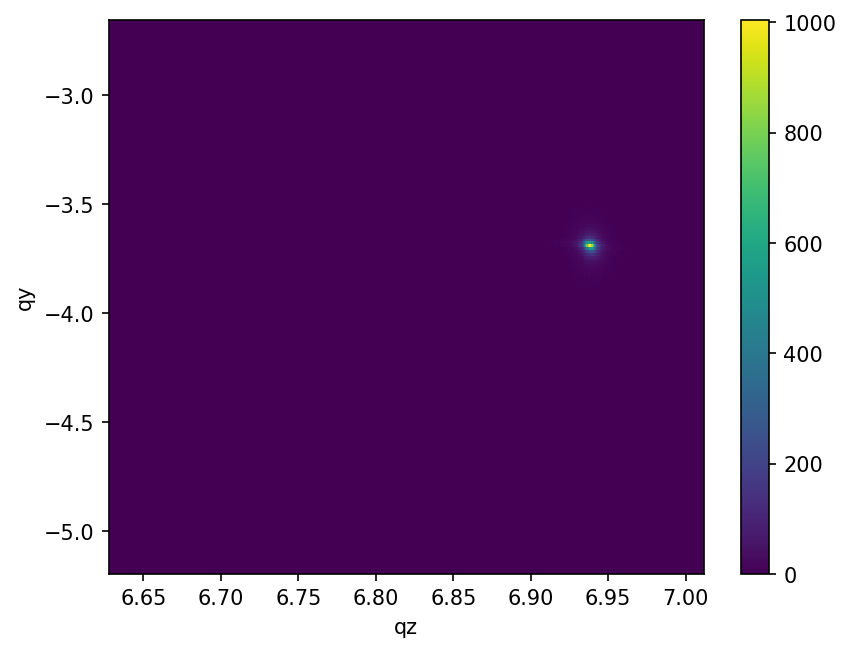

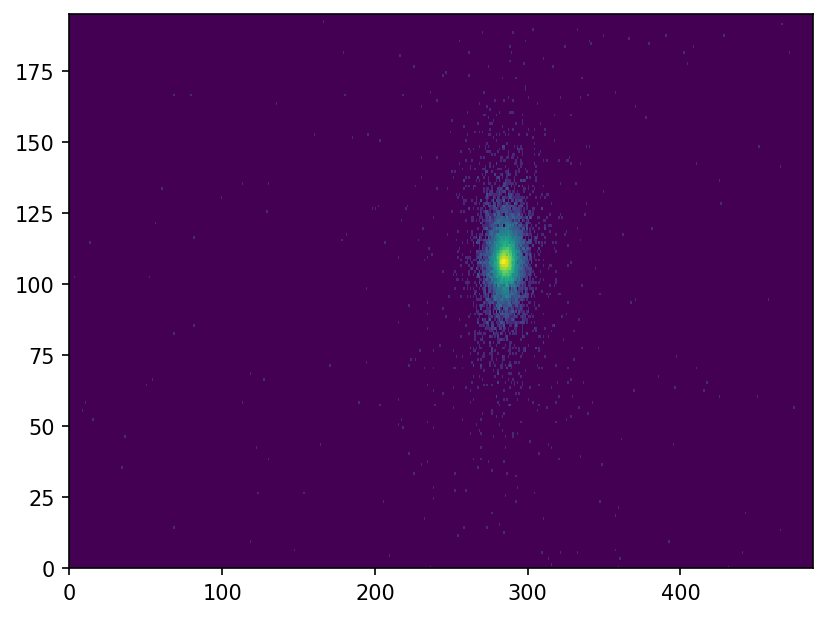

In [37]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcol

%matplotlib inline

plt.figure(10)
plt.pcolormesh(data[20]+1, norm=mcol.LogNorm())
plt.show()

### XRD interpretation of HDF5-like files

Do do real scientific work, we'll need that to interpret data according to
its scientific context. For XRD, this means that we will use the positioner
(i.e. angles) information we have to transform detector images into "Q-space maps",
a.k.a. "detector intensity images with Q-coordinates as their axes."

This is implemented mostly in the `nx5d.xrd.data` module. The central tool within that
module is the `ScanReader` object, which uses a data URL (`scanUrl` from above) and
an instrument specification.

In [8]:
from nx5d.xrd.data import ScanReader, SetupGenerator

#### The experiment specification

The first necessary step towards telling the computer how our experiment looks like.

The experiment specification is just a Python dictionary of which describes our goniometer,
sample and coordinate systems. We're using `xrayutilities` under the hood, so while the
information within an experiment specification dictionary tries to stay fairly general,
it is none the less strongly biased towards being easily fed into an
[HXRD experiment](https://xrayutilities.sourceforge.io/xrayutilities.html#xrayutilities.experiment.HXRD)
class of `xrayutilities.` This is an example of such an experimental setup definition:
```
{
    "goniometerAxes": ('y+', 'z+', 'x+'),
    "detectorTARAxes": (None, "z+", None),
    "imageAxes": ("x+", "z+"),
    
    "imageSize": (1024, 768),
    "imageCenter": (0.5, 0.5),
    "imageChannelSize": (1e-4, 1e-4),
    
    "sampleFaceUp": 'x+',
    "beamDirection": (0, 1, 0),
    "sampleNormal": (0, 0, 1),
    "beamEnergy": 9400.0,
    
    
    "detectorTARAngles": (0, 0, 0),
    "goniometerAngles": ("Theta", "Phi", "Chi"),  
}          
```

For our KMC3 beamline, the experimental setup is dynamically generated on a scan
by scan basis using the `nx5d.xrd.data.SetupGenerartor`.


#### Bonus: generating experiment setup from templates

*NOTE: This deals with the intricacies with templating the experimental setup
definitons and generating them on a scan-by-scan basis, as needed,
to provide information that might change from one scan to anoher. For simplicity
you can safely skip this section and just use the code below.*

If you're going to convert data from an unknown experiment, ultimately you need
to provide all these fields. Very few of the fields are allowed to be undefined
(i.e. `None`) -- in fact, the only such fields are some of the `detectorTARAxes`.
However, some information is not general or "static", but rather changeable on
a scan-by-scan basis (e.g. the `beamEnergy`). For this reason we prefer to work
not with *finished* experiment setup definitions, but with *templates*. These
have the same fields, but instead of directly usable information, they may
contain HDF5 paths of where to get that information on a scan-by-scan basis.
One such template would differ from the example above e.g. like this:
```
{
    "imageSize": ( "@{instrument}/rayonix/y_pixel_size",
                   "@{instrument}/rayonix/x_pixel_size" )
    ...
    "beamEnergy": "@{positioners}/beam_energy"
    ...
}
```

In this template example, for instance, we're requiring that the actual image
size in pixels after loading the data, from the specified variables.
It takes a specific HDF5-like container, containing specific scan data,
to actually generate a usable setup dictionary given a template like the above.
This is done by other `nx5d` components. One such component is, for instance,
the `SetupGenerator` class.

Currently `nx5d` provides experimetnal setup templates for some beamlines,
e.g. for the KMC3-XPP beamline (see `nx5d.xrd.kmc3.ExperimentTemplate`).

In [9]:
# the template
kmc3.ExperimentTemplate

{'goniometerAxes': ('x+', 'y+', 'z+'),
 'detectorTARAxes': ('x+', None, None),
 'imageAxes': ('x-', 'z-'),
 'imageSize': (195, 487),
 'imageCenter': (90, 245),
 'imageChannelSpan': None,
 'imageDistance': '@{positioners}/PilatusYOffset',
 'imageChannelSize': (0.172, 0.172),
 'sampleFaceUp': 'z+',
 'beamDirection': (0, 1, 0),
 'sampleNormal': (0, 0, 1),
 'beamEnergy': '@{positioners}/monoE',
 'goniometerAngles': {'theta': '@{positioners}/Theta',
  'chi': '@{positioners}/Chi',
  'phi': '@{positioners}/Phi'},
 'detectorTARAngles': {'azimuth': '@{positioners}/TwoTheta'}}

In [15]:
# compiling the template into an experiment setup definition based on the current h5like
exampleKmc3SetupGen = SetupGenerator(kmc3.ExperimentTemplate,
                                     paths={ 'positioners': 'instrument/positioners',
                                             'instrument':  'instrument',
                                             'measurement': 'measurement' }
                                    )
exampleKmc3SetupGen(h5like['44.1'])

{'goniometerAxes': ('x+', 'y+', 'z+'),
 'detectorTARAxes': ('x+', None, None),
 'imageAxes': ('x-', 'z-'),
 'imageSize': (195, 487),
 'imageCenter': (90, 245),
 'imageChannelSpan': None,
 'imageChannelSize': (0.172, 0.172),
 'sampleFaceUp': 'z+',
 'beamDirection': (0, 1, 0),
 'sampleNormal': (0, 0, 1),
 'beamEnergy': 9499.994}

### Reading the scan data

#### Defining experiment setup and initializing the `ScanReader`

Since some of our experimental parameters are inside the Spec file, will
only be available upon reading, and will change on a scan by scan basis,
we're using `SetupGenerator` to generate a setup
from the KMC3 template `nx5d.xrd.kmc3.ExperimentTemplate`. However,
sometimes (as in this case) we also want to override some experimental
parameters from the start, simply because they're either not available
in the Spec file at all, or because we want to supply our own values.

Here, we need to overide `"imageSize"` and `"imageChannelSize"` (a.k.a.
the pixel size).

We generate a template with customized entries by copying the KMC3 experiment
setup definition and changing the dictionary as needed.

In [17]:
partialTemplate = kmc3.ExperimentTemplate.copy()
partialTemplate.update({'imageSize': (195, 487),
                        'imageCenter': (90, 220)})

Now we have everything we need to define the scan reader object:

  - A scan file name / scan path (`scanUrl`)
  
  - A HDF5-like file reader (`nx5d.xrd.kmc3.SpecTiffH5`)
  
  - A usable experiment setup template containing valid values for everything
    except for the keys which will be filled in when the scan reader object
    will actually... *read* the scan (`partialTemplate`)

The next step is to define the scan reader object.

In [18]:
reader = ScanReader(kmc3.SpecTiffH5, scanUrl, setup=partialTemplate)

#### Direct reading of data frames and positioners

The central method of the `ScanReader` object is its `read()` method.
Most of the time you will be not using it directly (you will instead
use a higher-abstraction concepts like `ScanReader.Chunk`, introduced
in the next subsection.) However, it is important to understand how
`ScanReader.read()` works and what are the concepts behind it.

In its most simple form, `read()` expects two arguments:

  - a frame indexing object (`frameSlicer`) as its first parameter unnamed argument
  
  - any number of measurement data key(s) and path(s) as named arguments.

The "frame slicer" is either a number, indicating the index of the data frame (i.e. detector image) we want to retrieve; the data keys/paths the define which datasets of the HDF5 file *actually* make up the data we're interested in.

The `read()` method returns a dictionary which contains the keys we requested, holding the data we're interested in.

In the example below, the key `"image"` of the return data is the same as the
parameter `image=...` of the function call, and the numpy array that is returned
is frame 31 (of 41 in total) that is located at the path `"measurement/pilatus"` within
the HDF5 scan portion.

Of the two path compontents (`"measurement"` and `"pilatus"`) the latter is the
one we specified in the method call: `read(... image="pilatus")`. The former is
the default measurement data path. In accordance with ESRF-style HDF5/Nexus data
storage this is typically the `"measurement"` HDF5 group, but can be changed
when initializing the `ScanReader` object (refer to the documentation for details).

We can access data from all over the HDF5 scan group, for instance angles
from the `"positioner"` group. They will show up in the resulting data dictionary.

In [20]:
scanData = reader.read(31, image="pilatus", twotheta="@{positioners}/TwoTheta", chi="@{positioners}/Chi")
scanData

{'image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 'twotheta': 113.94,
 'chi': 0.3}

Note that the data key "chi" in this case is a scalar -- as is the corresponding
dataset in the HDF5-like file (`"instrument/positioners/Chi"`). As such, it
actually wouldn't be indexable by the interger index `31` that we specified
(you can try `h5like["/44.1/instrument/positionres/Chi"][31]` to convince
yourself).

However, donvenient behavior for `ScanData.read()` in cases like these is to
simply reproduce the scalar as it is, disregarding the indexing parameter
passed to `read()`. Keep in mind that this is only done for scalar datasets.
Any other datasets, e.g. with a non-matching shape or length (in our case:
a non-matching datacase, for instance, would be an array with 30 elements or
less) would raise an error. The intention is that all datasets available through
one `ScanReader` interface, if they are arrays, have the same length in their
first dimension: one record per frame.

After successfully retrieving a `scanData` dictionary, we are -- again -- 
able to plot a detector image frame. Only this time we obtained the frame using
the more abstract `ScanReader.read()` interface.

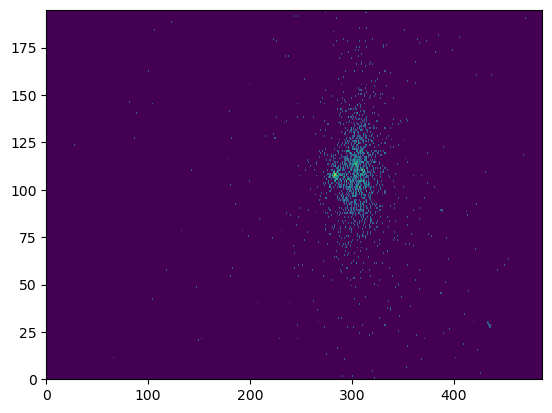

In [38]:
plt.figure(30)
plt.pcolormesh(scanData['image']+1, norm=mcol.LogNorm())
plt.show()

### Streak-based data processing

We have already learned that typical *scan* of experimental data consists of multiple
*frames* (i. e. detector images) -- each for a different set of positions, denoted by
an individual set of positioner variables.
However, *frame* => *scan* is not necessarily the only structure the data has; in many
cases there are other, non-positioning paramteres, which denote a subset of *frames*,
and several such subsets make finally make up a *scan*. We call these subsets *streaks*.

One *streak* differs from another typically by the fact that specific, non-positional
experimental parameters were change, for instance:

  - the time delay between an excitation and measurement (e.g. in pump-probe experiments)  
  - sample temperature (e.g. in measurements that involve temperature series)
  - aging of the sample, ...

#### Scan vs streak -- layout of frames inside a dataset

Streaking is an essential feature of experimental data, which needs to be taken
into account when reading and processing data.

In a series of X-ray diffraction images, an image scan is therefore virtually a series of
streaks (*seies* = [streak0, streak1, streak2, ... streakN]), with each streak being equally 
large and itself a series of frames (*chunk0* = [frame0, frame1, ... frameX],
*chunk1* = [frameX+1, frameX+2, ... frame2X], ...).

So in essence, when chunks are stored one after the other, the the typical scan data series
is a 3D dataset which typically looks like this:

  - [image1, image2, ... imageX, imageX+1, imageX+2, ...image2X, image2X+1, ...]
  
...where each *image* is of size WxH.
There is, however, also the possiblity that chunks are interweaved, making a *series*
look like this:

  - [image1, imageX+1, image2X+1, ...image2, imageX+2, image2X+2, ... imageN, imageX+N, ...]
  
In the latter case, one chunk is made up of every X-th image, while in the former, each
chunk is made up of equally large segments of X consecutive images.

#### Reading scans, one streak at a time

The method `streaks()` of `ScanReader` generates a series of *streaks* corresponding to
either the first type of layout (`streaks(length=...)`), or to the second type
(`streaks(delta=...)`). It also needs a list of HDF5 or measurement keys to actually read,
so the most simple call, e.g. for reading 4 "pieces" of 10 frames each, looks like the
following.


In [39]:
reader.streaks(length=10, image="pilatus")

<generator object ScanReader.streaks at 0x7f523033b1b0>

However, in our current dataset, there is no physically meaningful parameter other that the
positioners. We will therefore all the data at once, in one giant streak, corresponding
to the length of our scan. This is done by supplying neither `length` nor `delta` as parameter.

In [40]:
chks = [c for c in reader.streaks(image="pilatus")]
chk  = chks[0]

The resulting object is a dictionary containing the requested data (image) aswell as 
the data that we have passed as a parameter to the initialization of the `ScanReader`
object, the experimental setup.

In [41]:
chk

{'setup': {'goniometerAxes': ('x+', 'y+', 'z+'),
  'detectorTARAxes': ('x+', None, None),
  'imageAxes': ('x-', 'z-'),
  'imageSize': (195, 487),
  'imageCenter': (90, 220),
  'imageChannelSpan': None,
  'imageDistance': 155.0,
  'imageChannelSize': (0.172, 0.172),
  'sampleFaceUp': 'z+',
  'beamDirection': (0, 1, 0),
  'sampleNormal': (0, 0, 1),
  'beamEnergy': 9499.994,
  'goniometerAngles': {'theta': array([26.351093, 26.371094, 26.391094, 26.411095, 26.431093, 26.451094,
          26.471094, 26.491095, 26.511093, 26.531094, 26.551094, 26.571095,
          26.591093, 26.611094, 26.631094, 26.651094, 26.671095, 26.691093,
          26.711094, 26.731094, 26.751095, 26.771093, 26.791094, 26.811094,
          26.831095, 26.851093, 26.871094, 26.891094, 26.911095, 26.931093,
          26.951094, 26.971094, 26.991095, 27.011093, 27.031094, 27.051094,
          27.071095, 27.091093, 27.111094, 27.131094, 27.151094],
         dtype=float32),
   'chi': 0.3,
   'phi': 0.0},
  'detectorTARAngl

In [42]:
chk['image'].shape

(41, 195, 487)

This is how we access one  particular image of our data.

In [43]:
chk['image'][31]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

#### Angular-to-Q conversion

Further processing of data is performed by different modules within `nx5d`,
for instance `nx5d.xrd.signal`. There we have the `LazyQMap` class, which
takes a list of data sets and one experimental setup (as they are
contained within `chk`) and offer a angular-to-Q conversion based on
`xrayutilities`.


In [44]:
from nx5d.xrd.signal import LazyQMap

In [45]:
qtrans = LazyQMap(**chk)
qimg = qtrans("image")

This is all it takes to do the angular-to-Q conversion of our data.

The result dataset is an `xarray.DataArray` data set, which mostly can be used
like a `numpy` array, but has the benefit of holding intrinsical scaling
information. In this case, it contains the Q coordinate axes along the width
and the height of the image (sometimes also called $q_x$ and $q_z$, or $q_{||}$
and $q_{\perp}$ -- which is not always a correct description, which is why
we stick to "qw" and "qh").

(Note: if you are not already familiar with the
[xarray.DataArray](https://docs.xarray.dev/en/stable/user-guide/data-structures.html)
and its API, now is a good time to get acquainted.)

In [46]:
qimg

<xarray.DataArray (qx: 41, qy: 195, qz: 487)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * qx       (qx) float64 -0.5885 -0.5627 -0.5369 ... 0.3907 0.4164 0.4422
  * qy       (qy) float64 -5.192 -5.179 -5.165 -5.152 ... -2.686 -2.673 -2.66
  * qz       (qz) float64 6.628 6.629 6.629 6.63 6.631 ... 7.009 7.01 7.01 7.011

#### Leveraging `xarray`

With intrinsical scaling "all there", all other operations -- like slicing, interpolating,
integrating, and in particular plotting -- become a lot easier. Note how the following
plot already has the proper axis labeling in place.

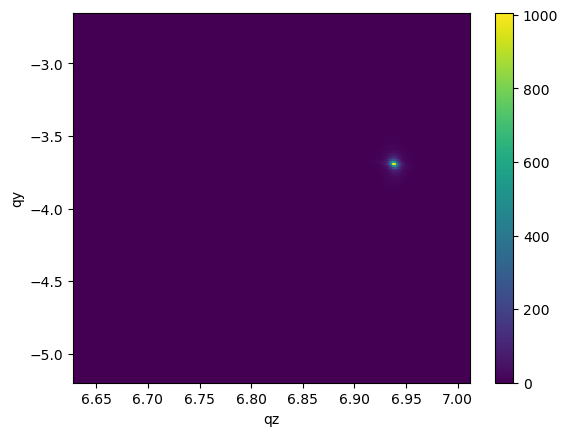

In [47]:
qimg.sum('qx').plot()